In [1]:
%matplotlib inline
import h5py
import numpy as np
from libero.lifelong.datasets import *
from libero.libero.utils.dataset_utils import get_dataset_info
from IPython.display import HTML
import imageio
from libero.libero import benchmark, get_libero_path, set_libero_default_path
import os
from termcolor import colored
import torch
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import cv2
from libero.lifelong.models import *
from libero.lifelong.utils import *

# load model and cfg

In [2]:
model_path = '/home/ruiqi/projects/meta_adapt/scripts/experiments/LIBERO_SPATIAL/PreTrainMultitask/BCViLTPolicy_seed10000/run_003/multitask_model_ep20.pth'
checkpoint = torch.load(model_path)
sd = checkpoint['state_dict']
cfg = checkpoint['cfg']
model = get_policy_class(cfg.policy.policy_type)(cfg, cfg.shape_meta)
model.load_state_dict(sd)

TASK_SUITE = cfg['task_creation']['task_suite']

# load trajectory

In [3]:
import pickle as pkl

TASK_ID = 0
INTERVAL = 20

online_traj_path = os.path.join('/', *model_path.split('/')[:-1], f'task_{TASK_ID}.pkl')
#online_traj_path = "/home/ruiqi/projects/meta_adapt/scripts/experiments/LIBERO_SPATIAL/PreTrainMultitask/BCViLTPolicy_seed10000/run_003/task_0.pkl"
with open(online_traj_path, 'rb') as f:
    task_obs = pkl.load(f)
    f.close()

TRAJ_ID = 1  # [0,4]

agentview_ims = [x['agentview_rgb'][TRAJ_ID] for x in task_obs]
eye_in_hand_ims = [x['eye_in_hand_rgb'][TRAJ_ID] for x in task_obs]

descriptions = []
benchmark_dict = benchmark.get_benchmark_dict()
benchmark_instance = benchmark_dict[TASK_SUITE]()

for i in range(benchmark_instance.n_tasks):
    task_description = benchmark_instance.get_task(i).language
    descriptions.append(task_description)
    print(f'task:{i}, {task_description}')


[info] using task orders [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
task:0, pick up the black bowl between the plate and the ramekin and place it on the plate
task:1, pick up the black bowl next to the ramekin and place it on the plate
task:2, pick up the black bowl from table center and place it on the plate
task:3, pick up the black bowl on the cookie box and place it on the plate
task:4, pick up the black bowl in the top drawer of the wooden cabinet and place it on the plate
task:5, pick up the black bowl on the ramekin and place it on the plate
task:6, pick up the black bowl next to the cookie box and place it on the plate
task:7, pick up the black bowl on the stove and place it on the plate
task:8, pick up the black bowl next to the plate and place it on the plate
task:9, pick up the black bowl on the wooden cabinet and place it on the plate


In [4]:

task_embs = get_task_embs(cfg, descriptions)[TASK_ID]
# select several frames
interval = len(agentview_ims) // INTERVAL
selected_agentview_ims = []
selected_eye_in_hand_ims = []
selected_agentview_ims.append(agentview_ims[0].cpu())
selected_eye_in_hand_ims.append(eye_in_hand_ims[0].cpu())
for i in range(0, len(agentview_ims), interval):
    selected_agentview_ims.append(agentview_ims[i].cpu())
    selected_eye_in_hand_ims.append(eye_in_hand_ims[i].cpu())
selected_agentview_ims.append(agentview_ims[-1].cpu())
selected_eye_in_hand_ims.append(eye_in_hand_ims[-1].cpu())
len(selected_agentview_ims)

27

In [5]:
ROWS = 4
COLS = 8

# visualize the original trajectory

In [6]:
def show_images(images_list, rows=4, cols=8, fig_size=(18, 10), save_fig=False, save_path=None,
                flip_transpose=False, to_numpy=False, unnormalize=False):
    # Create a figure and axes
    fig, axes = plt.subplots(rows, cols, figsize=fig_size)

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Plot each image in the grid
    for i, ax in enumerate(axes):
        if i < len(images_list):
            im_to_show = images_list[i]
            if to_numpy:
                im_to_show = im_to_show.numpy()
            if flip_transpose:
                im_to_show = im_to_show.transpose(1, 2, 0)[::-1]
            if unnormalize:
                im_to_show = (im_to_show * 255).astype(np.uint8)

            ax.imshow(im_to_show)
        ax.axis('off')  # Turn off axis

    # Adjust spacing
    plt.subplots_adjust(wspace=0.1, hspace=0.1)

    if not save_fig:
        # Show the plot
        plt.show()
    else:
        assert save_path is not None, "specify save path!"
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

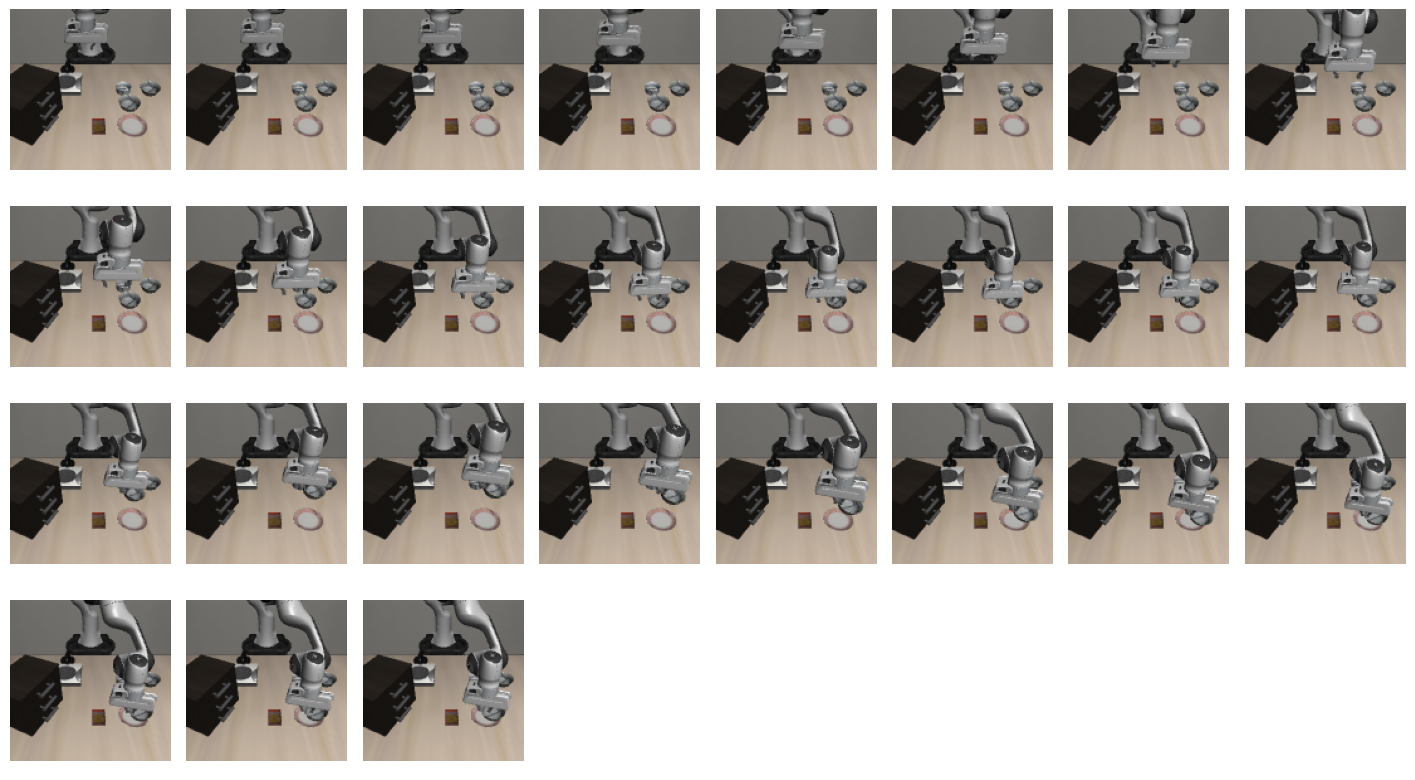

In [7]:
show_images(selected_agentview_ims, flip_transpose=True, to_numpy=True, rows=ROWS, cols=COLS)

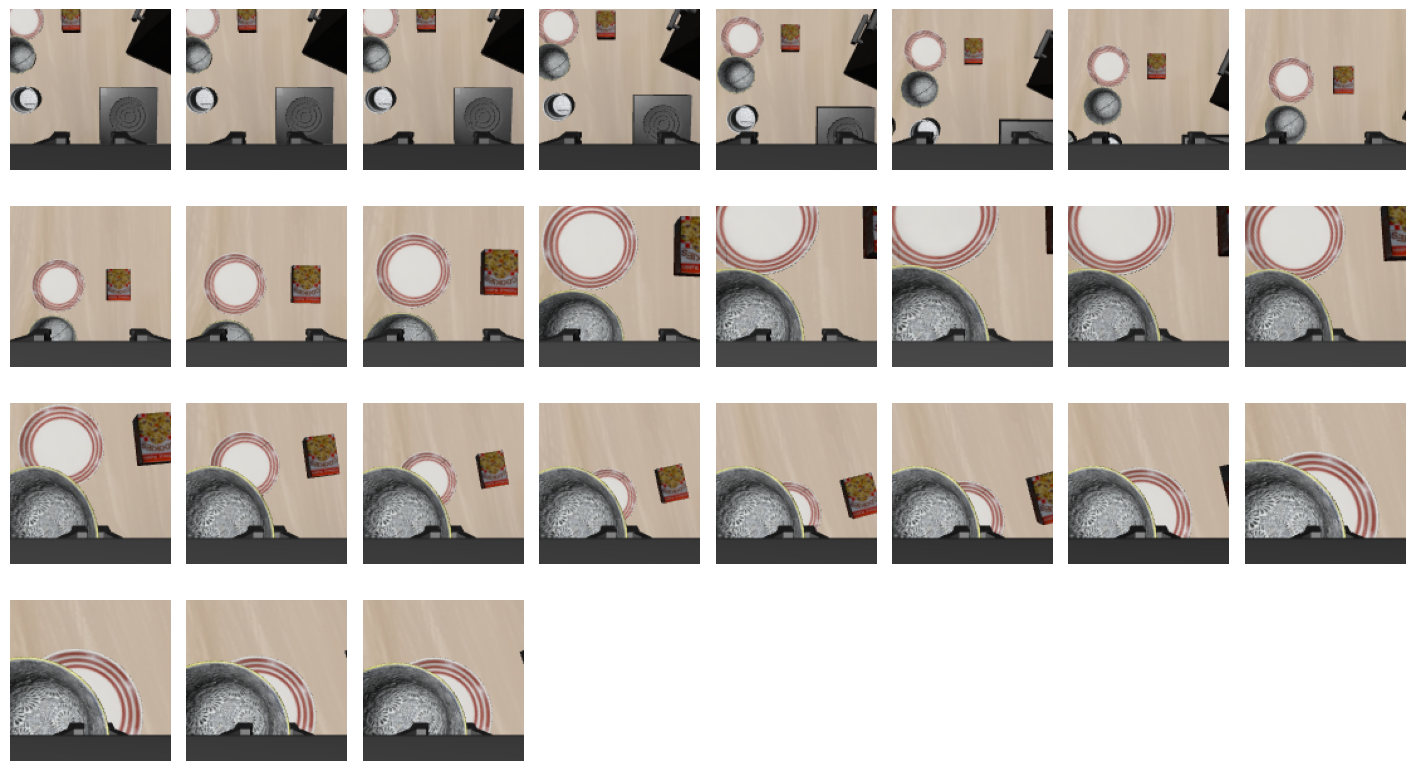

In [8]:
show_images(selected_eye_in_hand_ims, flip_transpose=True, to_numpy=True, rows=ROWS, cols=COLS)

# get the attention maps

## construct the input dataset

In [9]:
def construct_data(task_emb, agent_view_im, eye_in_hand_im):
    data = {}
    data['obs'] = {}
    data['obs']['agentview_rgb'] = agent_view_im
    data['obs']['eye_in_hand_rgb'] = eye_in_hand_im
    data['task_emb'] = task_emb
    return data

## get the attention maps at every spatial transformer layer

In [10]:
def get_att_maps_each_layer(data, model):
    att_maps = model.get_spatial_summary(data)
    att_maps_all_layer = []
    for i in range(len(att_maps)):
        att_maps_all_layer.append(att_maps[i])
    att_mat = torch.stack(att_maps_all_layer).squeeze(1)

    # Average the attention weights across all heads.
    att_mat = torch.mean(att_mat, dim=1)

    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    residual_att = torch.eye(att_mat.size(1))
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

    # Recursively multiply the weight matrices
    joint_attentions = torch.zeros(aug_att_mat.size())
    joint_attentions[0] = aug_att_mat[0]

    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n - 1])
    # agentview_im = data['obs']['agentview_rgb'][0, 0, :].numpy().transpose(1, 2, 0)
    # eye_in_hand_im = data['obs']['eye_in_hand_rgb'][0, 0, :].numpy().transpose(1, 2, 0)
    return joint_attentions


joint_att_list = []
for i in range(len(selected_agentview_ims)):
    temp = construct_data(task_embs, selected_agentview_ims[i][None, None, :],
                          selected_eye_in_hand_ims[i][None, None, :])
    joint_att = get_att_maps_each_layer(temp, model)
    joint_att_list.append(joint_att)


# cover original image with attention map at specific layer 

In [11]:
def cover_image_wt_att_map(att_map_list, layer_id, agentview_im_list, eye_in_hand_im_list):
    assert len(att_map_list) == len(agentview_im_list), "error"
    agentview_wt_att = []
    eye_in_hand_wt_att = []
    im_size = list(agentview_im_list[0].shape[1:])
    image_token_num = int((att_map_list[0].shape[1] - 2) / 2)
    for i in range(len(att_map_list)):
        v = att_map_list[i][layer_id]

        # get the att of the spatial summary token (index 0) over all other tokens
        agentview_att = v[0, 1:1 + image_token_num]
        agentview_att = agentview_att / agentview_att.sum()
        # print(agentview_att.sum())
        eye_in_hand_att = v[0, 1 + image_token_num:1 + 2 * image_token_num]
        eye_in_hand_att = eye_in_hand_att / eye_in_hand_att.sum()
        grid_size = 14

        mask_agentview = agentview_att.reshape(grid_size, grid_size).detach().numpy()
        mask_agentview = cv2.resize(mask_agentview / mask_agentview.max(), im_size)[np.newaxis, ...]

        mask_eye_in_hand = eye_in_hand_att.reshape(grid_size, grid_size).detach().numpy()
        mask_eye_in_hand = cv2.resize(mask_eye_in_hand / mask_eye_in_hand.max(), im_size)[np.newaxis, ...]

        agentview_wt_att.append(agentview_im_list[i] * mask_agentview)
        eye_in_hand_wt_att.append(eye_in_hand_im_list[i] * mask_eye_in_hand)
    return agentview_wt_att, eye_in_hand_wt_att


agentview_wt_att_list, eye_in_hand_wt_att_list = cover_image_wt_att_map(joint_att_list, -1, selected_agentview_ims,
                                                                        selected_eye_in_hand_ims)


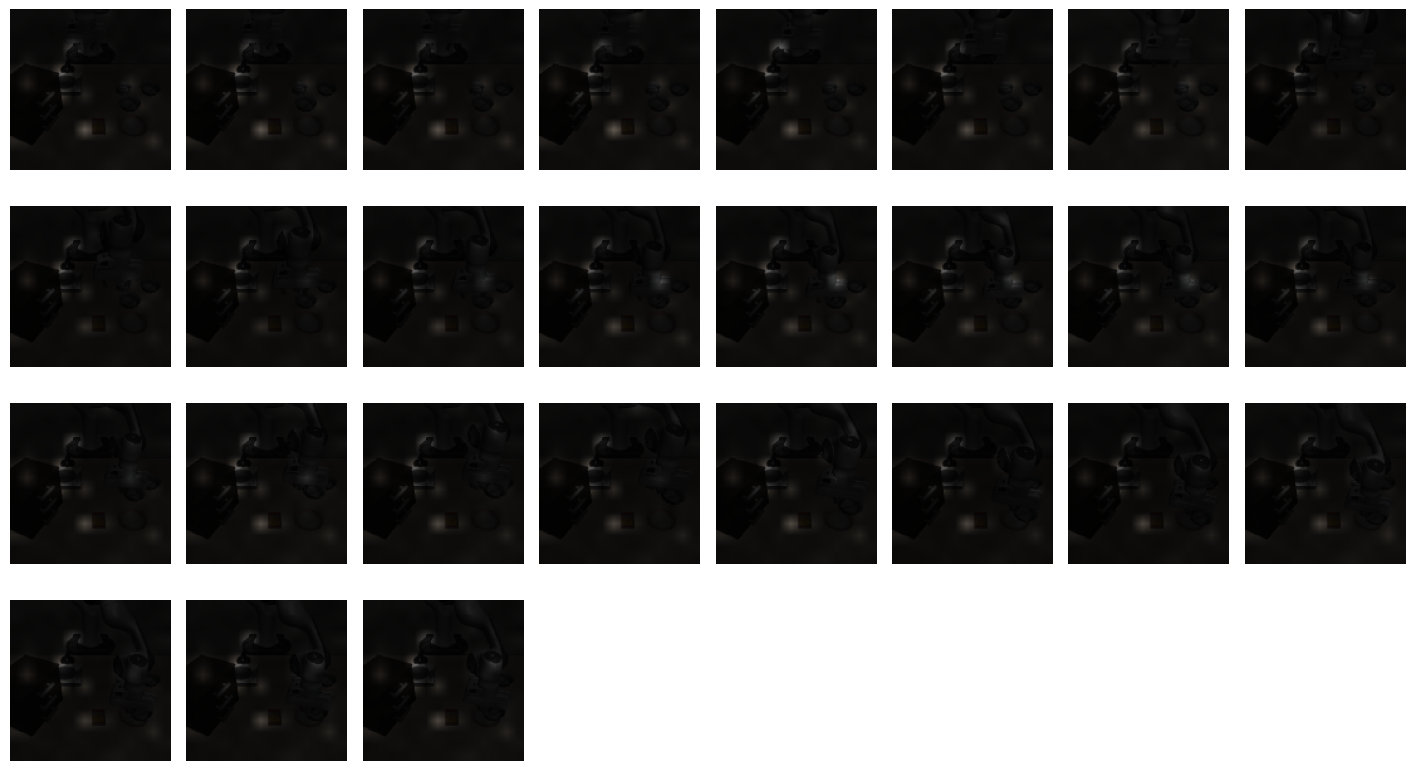

In [12]:
show_images(agentview_wt_att_list, flip_transpose=True, to_numpy=True, rows=ROWS, cols=COLS)

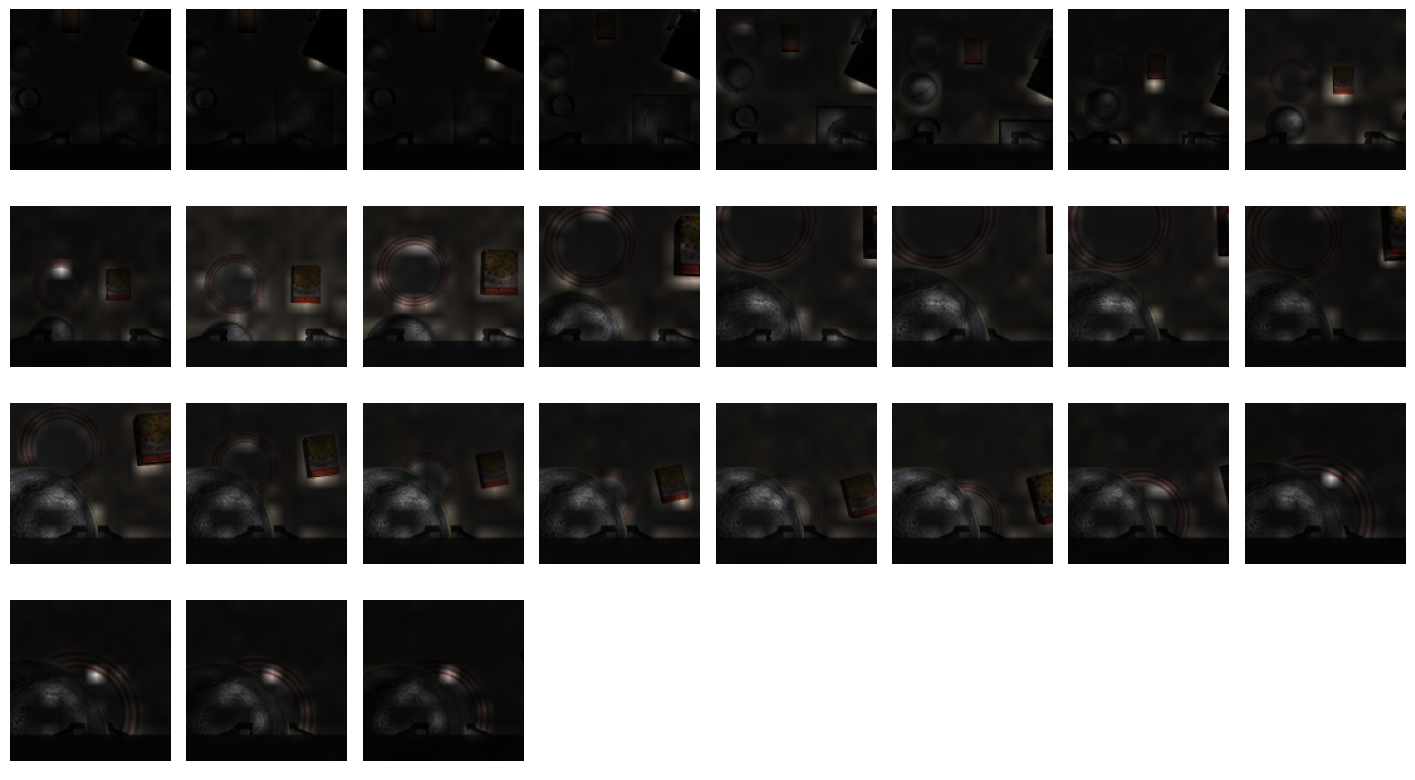

In [13]:
show_images(eye_in_hand_wt_att_list, flip_transpose=True, to_numpy=True, rows=ROWS, cols=COLS)